## Step1. Setup

In [10]:
from platform import python_version
print(python_version())

3.8.0


In [52]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.1


In [12]:
### install keras-tuner
## python3 -m pip install --user keras-tuner 
import kerastuner as kt

## Step 2. Download and prepare the dataset 

we will use the Fashion MNIST dataset, ie. images of clothing. 

In [13]:
(img_train, label_train), (img_test, label_test) = keras.datasets.fashion_mnist.load_data()

In [18]:
## lets check the number of train/test images
print('No of train images: ', img_train.shape)
print('No of test images: ', img_test.shape)
print('label format for trainig:', label_train.shape)
print('label format for testing:', label_test.shape)

No of train images:  (60000, 28, 28)
No of test images:  (10000, 28, 28)
label format for trainig: (60000,)
label format for testing: (10000,)


In [19]:
## Normalize the dataset
img_train = img_train.astype('float32')/255.0
img_test = img_test.astype('float32')/255.0

## Step 3. Define the model

while building a model for hypertuning, one should define the hyperparamet search spave in addition to the model architecture.
The model setup for hypertuning is called a hypermodel. It could be defined through two approaches:
    
    * By using a model builder function
    * By subclassing the HyperModel class of the Keras Tuner API

In [28]:
def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    model.add(keras.layers.Dense(10))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    return model

### Instentiate the tuner and perform hypertuning

1. keras tuner has four tuners: RandomSearch, Hyperband, BayesianOptimization and Sklearn
2. To instentiate the Hyperband tuner, one must specify the hypermodel, the 'pobjective' to optimize and the  maximum number of epoches to train 'max_epochs'

In [25]:
## ?kt.Hyperband

In [29]:
tuner = kt.Hyperband(model_builder, 
                    objective='val_accuracy',
                    max_epochs=10,
                    factor=3, # Int. Reduction factor for the number of epochs/number of models for each bracket.
                    directory='my_dir',
                    project_name='intro_to_tuning')

In [30]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [31]:
tuner.search(img_train, label_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

## get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The Optimal number of units in the first dense layeer is {best_hps.get('units')} and 
the optimal learning rate for the optimal learning_rate is {best_hps.get('learning_rate')}""")

Trial 30 Complete [00h 00m 41s]
val_accuracy: 0.8922500014305115

Best val_accuracy So Far: 0.8922500014305115
Total elapsed time: 00h 05m 53s
INFO:tensorflow:Oracle triggered exit

The Optimal number of units in the first dense layeer is 512 and 
the optimal learning rate for the optimal learning_rate is 0.001


## Step 4. Train the Model

Find the optimal number of epoches to train the model with the hyperparameter obrained from the search.



In [32]:
# Build the model with the optimal hyperparamers and train it on the data for 50 epochs
model=tuner.hypermodel.build(best_hps)
history=model.fit(img_train, label_train, epochs=50, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) +1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6049 - accuracy: 0.7848 - val_loss: 0.4129 - val_accuracy: 0.8533
Epoch 2/50
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3763 - accuracy: 0.8632 - val_loss: 0.3914 - val_accuracy: 0.8608
Epoch 3/50
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3347 - accuracy: 0.8763 - val_loss: 0.3311 - val_accuracy: 0.8816
Epoch 4/50
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2992 - accuracy: 0.8892 - val_loss: 0.3287 - val_accuracy: 0.8808
Epoch 5/50
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2831 - accuracy: 0.8930 - val_loss: 0.3240 - val_accuracy: 0.8801
Epoch 6/50
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2674 - accuracy: 0.8984 - val_loss: 0.3270 - val_accuracy: 0.8837
Epoch 7/50
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2550 - accuracy: 0.9078 - val_loss: 0.3487 - val_accuracy:

In [61]:
## to plot four plots side by side
fig = plt.figure()
fig.patch.set_facecolor('white')

def plot_2(history=history,
          ylim_low=0.4, ylim_high=1.0, 
          label_list=[]    ,       
          leg_loc='lower left'):
    fig = plt.figure(figsize=(15,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label=label_list[0], c='green', ls='-')
    plt.plot(history.history['val_accuracy'],label=label_list[1], c='green',ls='--')

    plt.ylabel('accuracy')
    plt.xlabel('Epoch')
    plt.grid(True)
    plt.legend(loc=leg_loc)

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label=label_list[0], c='red', ls='-')
    plt.plot(history.history['val_loss'],label=label_list[1],  c='red',ls='--')

    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.grid(True)
    plt.legend(loc=leg_loc)
    plt.ylim(ylim_low,ylim_high)

<Figure size 432x288 with 0 Axes>

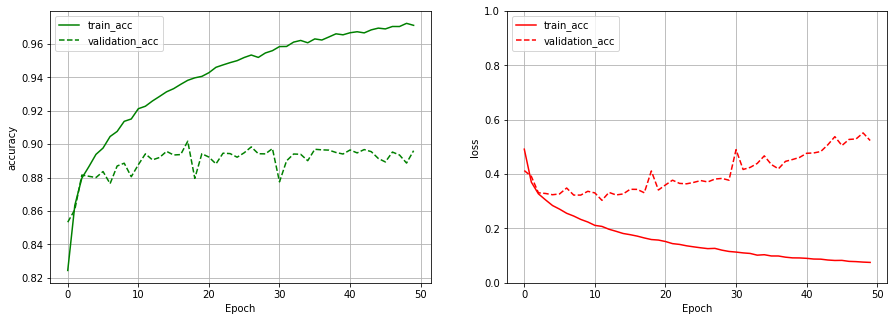

In [63]:
plot_2(history=history, label_list=['train_acc', 'validation_acc'], ylim_low=0, leg_loc='upper left')

In [64]:
## Reinstiate the hypermodel and train it with optimal nunber of epoches

hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.fit(img_train, label_train, epochs=best_epoch, validation_split=0.2)

Epoch 1/18
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6214 - accuracy: 0.7843 - val_loss: 0.4287 - val_accuracy: 0.8420
Epoch 2/18
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3806 - accuracy: 0.8628 - val_loss: 0.3686 - val_accuracy: 0.8688
Epoch 3/18
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3329 - accuracy: 0.8763 - val_loss: 0.3547 - val_accuracy: 0.8690
Epoch 4/18
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2995 - accuracy: 0.8902 - val_loss: 0.3435 - val_accuracy: 0.8745
Epoch 5/18
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2837 - accuracy: 0.8948 - val_loss: 0.3507 - val_accuracy: 0.8737
Epoch 6/18
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2692 - accuracy: 0.8983 - val_loss: 0.3181 - val_accuracy: 0.8900
Epoch 7/18
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2526 - accuracy: 0.9060 - val_loss: 0.3118 - val_accuracy:

## Step 5. Evaluate on test data

In [65]:
## Evaluate the hyoermodel on the test data
eval_result =hypermodel.evaluate(img_test, label_test)
print("[test loss, test accuracy]:", eval_result)

313/313 [==============================] - 1s 2ms/step - loss: 0.3791 - accuracy: 0.8840
[test loss, test accuracy]: [0.3790961802005768, 0.8840000033378601]


## Referenz.

[kerastuner_on_RandomForest](https://github.com/keras-team/keras-tuner)